<a href="https://colab.research.google.com/github/Danika-Balas/msds-458/blob/master/PCam_110k_Final_Tests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction

Data is a modified version of the PCam dataset--duplicates have been removed. The goal is to classify the images as cancerous or non-cancerous. A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label.
https://www.kaggle.com/c/histopathologic-cancer-detection/data?select=train_labels.csv 

###Acknowledgements
Code was adapted from the following sources:

Deep Learning with Python by Francis Chollet

https://www.kaggle.com/gomezp/complete-beginner-s-guide-eda-keras-lb-0-93

https://www.kaggle.com/vbookshelf/cnn-how-to-use-160-000-images-without-crashing

https://www.kaggle.com/artgor/simple-eda-and-model-in-pytorch


#Setup and Preprocessing

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
#%matplotlib inline
#sns.set(style="whitegrid")

from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score

import os, random
from random import shuffle
import cv2 #image processing
from glob import glob #for easily finding matching filenames 
from tqdm import tqdm, tqdm_notebook, trange #progress bar
import gc #garbage collection, for saving RAM

import tensorflow as tf
from tensorflow import keras
keras.__version__

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


'2.3.0-tf'

In [3]:
from keras import metrics
from keras import models
from keras import layers

Using TensorFlow backend.


##Upload data

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Code executed once to unzip the files, then commented out:

In [0]:
# #unzip set of training files (smaller dataset to make sure it works)
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/sampleTrain.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain"

In [6]:
#Check whether sample files are readable
sample_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/sampleTrain/sampleTrain')
print(f'{len(sample_names)} files in sample directory')
print(sample_names[:5])

10 files in sample directory
['00a0ad1de2cdf805f02c524a985bca5bce1d1b5f.tif', '0a0a8bdf1d78af77dcc0b94aef6fb5c2f841a3c0.tif', '0a0a2e923bdedb11f270dcd3f11d0f001df98f00.tif', '0a0d1a09e5cf9fcc308ecdc210450aecd204d344.tif', '0a0b4604d66cecfe668e26383c22fafb74484eef.tif']


Started with 10,000 training files in order develop model

Be sure to change path below when adding more files

In [0]:
# #unzip set of training files
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/train110P.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/train"

In [0]:
# drive.mount("/content/drive", force_remount=True)

In [0]:
#Check whether sample files are readable
train_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/train/train110P')
print(f'{len(train_names)} files in training directory')
print(train_names[:5])

Code below to unzip testing data. It has not been run yet it order to save space on Drive.

In [0]:
# #unzip set of testing files 
# !unzip -uq "/content/drive/My Drive/MSDS 458/PCam/test.zip" -d "/content/drive/My Drive/MSDS 458/PCam/unzipped/test"

In [0]:
# #Check whether sample files are readable
# test_names = os.listdir('/content/drive/My Drive/MSDS 458/PCam/unzipped/test')
# print(f'{len(test_names)} files in testing directory')
# print(test_names[:5])

##Set paths

In [0]:
path = '/content/drive/My Drive/MSDS 458/PCam/unzipped/'
train_path = path+'train/train110P'
test_path =  path+'test/'
sample_path = path+'sampleTrain/sampleTrain'  #contains 10 images, simply for testing data can be read

##Load labels and filenames

In [0]:
labels = pd.read_csv('/content/drive/My Drive/MSDS 458/PCam/train_labels.csv')

In [9]:
df = pd.DataFrame({'path': glob(os.path.join(train_path,'*.tif'))}) # load the filenames
df['id'] = df.path.map(lambda x: x.split('/')[9].split(".")[0]) # keep only the file names in 'id'
df.head()

,path,id
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6c1f0477cd23d1ba4adf36bc77b510ab3e4597a4
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,023f48b947a947fffd4396db4358401cf423a919
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9bb3ce91e19ba3158ba8ff7340f8003a4a2ac084
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,17aefb86a10ae4f6f71e259f34bbc34648ed0713
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,8e54ac7bb39fecf0ff4617a829efdca0e6fadab4


In [0]:
df = df.merge(labels, on = "id") # merge labels and filepaths

In [11]:
df.head(5) # print the first five entries

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,6c1f0477cd23d1ba4adf36bc77b510ab3e4597a4,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,023f48b947a947fffd4396db4358401cf423a919,1
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,9bb3ce91e19ba3158ba8ff7340f8003a4a2ac084,1
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,17aefb86a10ae4f6f71e259f34bbc34648ed0713,0
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,8e54ac7bb39fecf0ff4617a829efdca0e6fadab4,0


In [12]:
print(df.count) #check total number of rows in dataframe

<bound method DataFrame.count of                                                      path  ... label
0       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
1       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
2       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
3       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
4       /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
...                                                   ...  ...   ...
109098  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
109099  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0
109100  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
109101  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     1
109102  /content/drive/My Drive/MSDS 458/PCam/unzipped...  ...     0

[109103 rows x 3 columns]>


In [16]:
df['label'].value_counts()

0    64978
1    44125
Name: label, dtype: int64

In [20]:
64978/109103
#44125/109103

0.5955656581395562

Did not balance out the classes, retained 60:40 ratio

##Balancing out classes, since 40% are in class 1

In [13]:
# create dataframe with all of the class 1 samples
df_1 = df[df['label']==1]
sample_size = len(df_1)
sample_size

44125

In [0]:
# take a random sample of class 0 that is equal to the number of samples in class 1
df_0 = df[df['label']==0].sample(sample_size, random_state = 42)

In [15]:
# concatenate the dataframes
df_equal = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
df_equal['label'].value_counts()

1    44125
0    44125
Name: label, dtype: int64

In [138]:
df_equal.head()

,path,id,label
0,/content/drive/My Drive/MSDS 458/PCam/unzipped...,4cf42ad0c370104b7cd2f21ec66b4090b14ce926,0
1,/content/drive/My Drive/MSDS 458/PCam/unzipped...,2d6d848a6c96d40a60220a54b0a44f742535bd1b,0
2,/content/drive/My Drive/MSDS 458/PCam/unzipped...,86e527fe4f1b6e36f5b9a04089f7c645bf15b453,0
3,/content/drive/My Drive/MSDS 458/PCam/unzipped...,5fd5eb8d5785411a7f91374393133fd53ccf55b6,0
4,/content/drive/My Drive/MSDS 458/PCam/unzipped...,3fcab672147042d87357062efaaafe9b4179e9eb,0


##Load images

In [0]:
def load_data(N,df):
    """ This functions loads N images using the data df
    """
    # allocate a numpy array for the images (N, 96x96px, 3 channels, values 0 - 255)
    X = np.zeros([N,40,40,3],dtype=np.uint8) 
    #convert the labels to a numpy array too
    dfLabel=df['label']
    y = np.squeeze(dfLabel.to_numpy())[0:N]
    #read images one by one, tdqm notebook displays a progress bar
    for i, row in tqdm_notebook(df.iterrows(), total=N):
        if i == N:
            break
        X[i] = cv2.imread(row['path'])

    # Scale the data to [0,1] interval
    X = X.astype('float16')/255      #comment out to perform EDA steps
    return X,y

In [0]:
# Load some of the images
N=10000
X,y = load_data(N=N,df=df) #this is from dataframe that is not uniformly distributed, but is shuffled

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


##EDA

View some sample images. Non-cancerous samples are labeled 0, and cancerous samples are labeled 1.

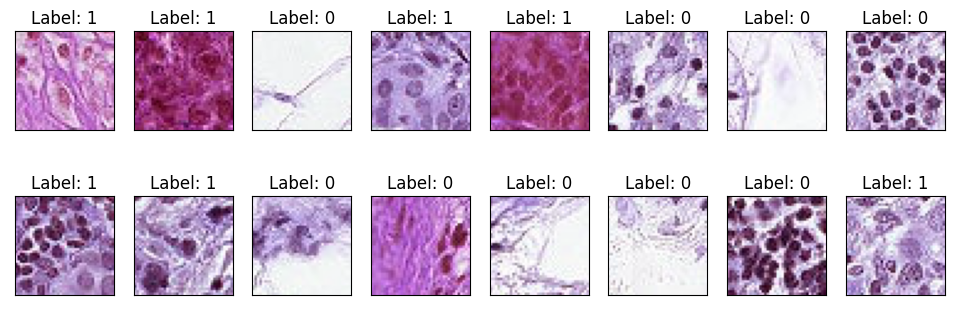

In [0]:
fig = plt.figure(figsize=(12, 4), dpi=100)
np.random.seed(777) #we can use the seed to get a different set of random images
for plotNr,idx in enumerate(np.random.randint(0,N,16)):
    ax = fig.add_subplot(2, 16//2, plotNr+1, xticks=[], yticks=[]) #add subplots
    plt.imshow(X[idx]) #plot image
    ax.set_title('Label: ' + str(y[idx])) #show the label corresponding to the image

Evaluate the distribution of the two classes

Text(0, 0.5, 'Samples')

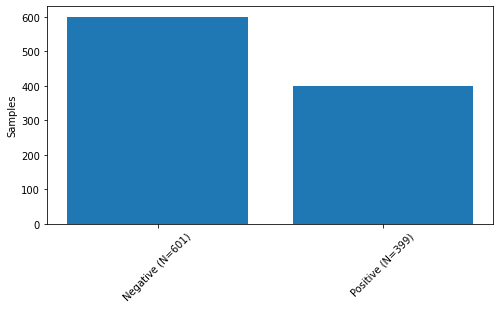

In [0]:
plt.figure(figsize=[8,4])
plt.bar([0,1], [(y==0).sum(), (y==1).sum()])
plt.axis()
plt.xticks([0,1],[f"Negative (N={(y==0).sum()})",f"Positive (N={(y==1).sum()})"],rotation=45)
#plt.xticks(rotation=45)
#plt.rc('xtick',labelsize=10)
plt.ylabel('Samples')


In [0]:
print(f"{round((y==1).sum()/len(y)*100,2)}% of the samples are positive.") 
print(f"We need to clear the baseline of {round((y==0).sum()/len(y)*100,2)}%, which would be the accuracy if we predicted that all of the samples were non-cancerous.")

39.9% of the samples are positive.
We need to clear the baseline of 60.1%, which would be the accuracy if we predicted that all of the samples were non-cancerous.


###To evaluate the classes individually

In [0]:
positive_samples = X[y == 1]
negative_samples = X[y == 0]

Look at the distribution of the pixels for each color channel

In [0]:
# nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
# fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

# #RGB channels
# axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
# axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
# axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
# axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

# #All channels
# axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
# axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

# #Set image labels
# axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
# axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
# axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
# axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
# axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
# axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
# for i in range(4):
#     axs[i,0].set_ylabel("Relative frequency")
# axs[3,0].set_xlabel("Pixel value")
# axs[3,1].set_xlabel("Pixel value")
# fig.tight_layout()

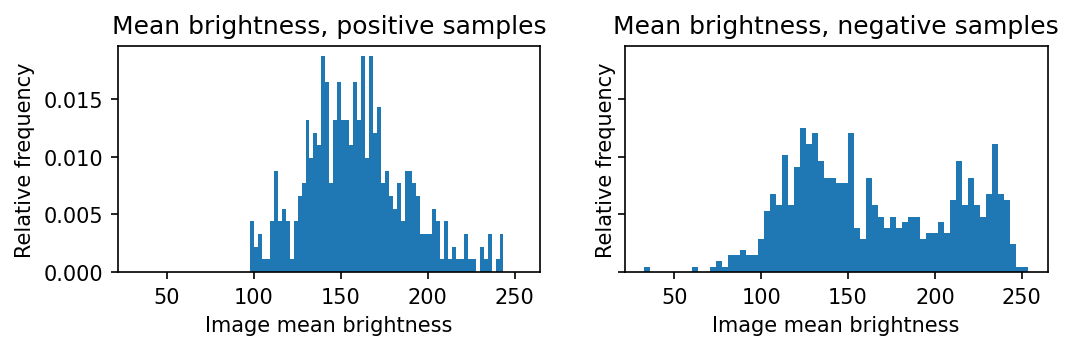

In [0]:
nr_of_bins = 64 #we use a bit fewer bins to get a smoother image
fig,axs = plt.subplots(1,2,sharey=True, sharex = True, figsize=(8,2),dpi=150)
axs[0].hist(np.mean(positive_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[1].hist(np.mean(negative_samples,axis=(1,2,3)),bins=nr_of_bins,density=True);
axs[0].set_title("Mean brightness, positive samples");
axs[1].set_title("Mean brightness, negative samples");
axs[0].set_xlabel("Image mean brightness")
axs[1].set_xlabel("Image mean brightness")
axs[0].set_ylabel("Relative frequency")
axs[1].set_ylabel("Relative frequency");

In [0]:
#Clean up variables to free up RAM
#Collect garbage
positives_samples = None
negative_samples = None
gc.collect();

#Prepare data for modeling

In [139]:
#Load remainder of dataset
X_equal = None
y_equal = None
gc.collect();
#using df with same number of samples per class
N = df_equal["path"].size # get the number of images in the training data set
X_equal,y_equal = load_data(N=N,df=df_equal)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.


In [140]:
X_equal[1]

array([[[0.5254 , 0.1137 , 0.2903 ],
        [0.6196 , 0.196  , 0.3765 ],
        [0.5176 , 0.0941 , 0.2627 ],
        ...,
        [0.5767 , 0.1882 , 0.408  ],
        [0.7295 , 0.3176 , 0.612  ],
        [0.749  , 0.3372 , 0.647  ]],

       [[0.718  , 0.302  , 0.51   ],
        [0.608  , 0.1804 , 0.4    ],
        [0.5215 , 0.098  , 0.306  ],
        ...,
        [0.4824 , 0.0863 , 0.306  ],
        [0.4548 , 0.04706, 0.3254 ],
        [0.8276 , 0.4353 , 0.718  ]],

       [[0.6    , 0.1921 , 0.4392 ],
        [0.8433 , 0.4392 , 0.706  ],
        [0.796  , 0.4119 , 0.6704 ],
        ...,
        [0.612  , 0.2157 , 0.4353 ],
        [0.678  , 0.2903 , 0.533  ],
        [0.749  , 0.3726 , 0.6235 ]],

       ...,

       [[0.612  , 0.2118 , 0.3726 ],
        [0.537  , 0.1372 , 0.353  ],
        [0.7764 , 0.3882 , 0.6704 ],
        ...,
        [0.2864 , 0.     , 0.1412 ],
        [0.863  , 0.4824 , 0.7725 ],
        [0.7217 , 0.3333 , 0.6    ]],

       [[0.5923 , 0.2079 , 0.3804 ],
  

In [0]:
#Load remainder of dataset
X_ = None
y = None
gc.collect();
#using df with same number of samples per class
N = df["path"].size # get the number of images in the training data set
X,y = load_data(N=N,df=df)

In [23]:
X[1]

array([[[0.604 , 0.3647, 0.655 ],
        [0.686 , 0.4392, 0.7295],
        [0.655 , 0.3882, 0.6904],
        ...,
        [0.4746, 0.2079, 0.4626],
        [0.643 , 0.396 , 0.6665],
        [0.643 , 0.408 , 0.686 ]],

       [[0.702 , 0.4863, 0.7725],
        [0.6587, 0.443 , 0.753 ],
        [0.698 , 0.4785, 0.8037],
        ...,
        [0.4746, 0.1843, 0.4119],
        [0.612 , 0.3098, 0.6   ],
        [0.698 , 0.396 , 0.7256]],

       [[0.5605, 0.2744, 0.549 ],
        [0.686 , 0.4197, 0.7217],
        [0.682 , 0.4392, 0.7607],
        ...,
        [0.937 , 0.6943, 0.8823],
        [0.5806, 0.2825, 0.565 ],
        [0.506 , 0.1647, 0.51  ]],

       ...,

       [[0.7725, 0.5176, 0.816 ],
        [0.8745, 0.6353, 0.886 ],
        [0.7217, 0.51  , 0.6943],
        ...,
        [0.541 , 0.2903, 0.5728],
        [0.682 , 0.4   , 0.7217],
        [0.796 , 0.5176, 0.8315]],

       [[0.5923, 0.3215, 0.6353],
        [0.6904, 0.4275, 0.7217],
        [0.7686, 0.5254, 0.784 ],
        .

##Train test split

In [0]:
# Split into train and test (80/20)
from sklearn.model_selection import train_test_split
#not setting a random_state and not shuffling because samples are already shuffled and want to save RAM 
# added random state instead of shuffle=False
X_train, X_test, y_train, y_test = train_test_split(X_equal, y_equal, test_size=0.2, random_state=42)

In [142]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((70600, 40, 40, 3), (17650, 40, 40, 3), (70600,), (17650,))

In [0]:
# X = None
# y = None
# gc.collect();

#Define callbacks for training/testing times

In [0]:
# Define callback to get total training time
import datetime

class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [0]:
# Define callback to get total test time
import datetime

class TestRuntimeCallback(keras.callbacks.Callback):

  def on_test_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_test_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

#Experiment 1:DNN
Establish a baseline with a simple two layer DNN.

##Build and compile the model

In [143]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(40, 40, 3)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 200)               960200    
_________________________________________________________________
dense_26 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_17 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 101       
Total params: 980,401
Trainable params: 980,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [145]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 60010 samples, validate on 10590 samples
Epoch 1/15
60010/60010 [==============================] - 6s 99us/step - loss: 0.6761 - accuracy: 0.5855 - val_loss: 0.6535 - val_accuracy: 0.5976
Epoch 2/15
60010/60010 [==============================] - 6s 94us/step - loss: 0.6445 - accuracy: 0.6139 - val_loss: 0.6361 - val_accuracy: 0.6116
Epoch 3/15
60010/60010 [==============================] - 6s 94us/step - loss: 0.6397 - accuracy: 0.6178 - val_loss: 0.6415 - val_accuracy: 0.6121
Epoch 4/15
60010/60010 [==============================] - 6s 94us/step - loss: 0.6375 - accuracy: 0.6217 - val_loss: 0.6401 - val_accuracy: 0.6227
Epoch 5/15
60010/60010 [==============================] - 6s 93us/step - loss: 0.6345 - accuracy: 0.6228 - val_loss: 0.6294 - val_accuracy: 0.6237
Epoch 6/15
60010/60010 [==============================] - 6s 94us/step - loss: 0.6297 - accuracy: 0.6340 - val_loss: 0.6233 - val_accuracy: 0.6209
Epoch 7/15
60010/60010 [==============================] - 6s 94us/st

In [146]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

85.106282

##Test the model

In [147]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

17650/17650 [==============================] - 2s 112us/step


(0.5778370816444203, 0.7130311727523804)

In [148]:
test_time = test_rt.process_time
test_time # in seconds

1.986335

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

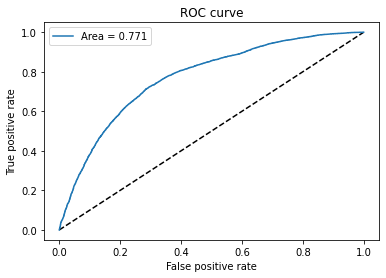

In [151]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

### Create a dataframe for the training and test statistics

In [152]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [153]:
history_df=pd.DataFrame(history_dict)
history_df.tail()

,val_loss,val_accuracy,loss,accuracy
10,0.583989,0.689235,0.594293,0.687769
11,0.577204,0.701983,0.589703,0.695001
12,0.579335,0.693957,0.586603,0.697967
13,0.585419,0.698678,0.584912,0.700517
14,0.576283,0.711237,0.583605,0.703883


In [154]:
results_df = history_df.iloc[-1:].copy()
results_df.insert(0,'model','DNN (2 layer)') 
results_df['test_loss'] = test_loss #incorporate test results
results_df['test_accuracy'] = test_acc
results_df['auroc'] = auc_keras
results_df['train time'] = train_time    
results_df['test time'] = test_time    
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,DNN (2 layer),0.576283,0.711237,0.583605,0.703883,0.577837,0.713031,0.771145,85.106282,1.986335


### Plotting the performance 

We use Matplotlib to create 2 plots--displaying the training and validation loss/accuracy for each training epoch side by side.

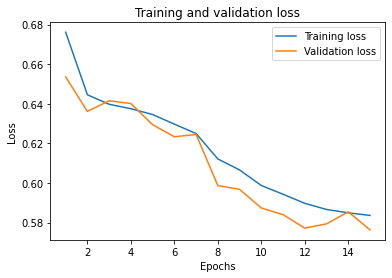

In [155]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

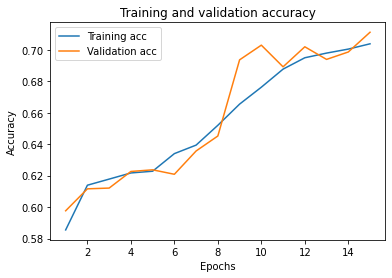

In [156]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Experiment 2: DNN

This model is the same as in Experiment 1, but with a batch size of 1000 instead of 100.

First hidden layer has 200 nodes, second hidden layer has 100 nodes.

##Build and compile the model

In [157]:
model = models.Sequential()

model.add(layers.Flatten(input_shape=(40, 40, 3)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 4800)              0         
_________________________________________________________________
dense_28 (Dense)             (None, 200)               960200    
_________________________________________________________________
dense_29 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_18 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 101       
Total params: 980,401
Trainable params: 980,401
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [159]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=20,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 60010 samples, validate on 10590 samples
Epoch 1/20
60010/60010 [==============================] - 3s 43us/step - loss: 0.7507 - accuracy: 0.5562 - val_loss: 0.6988 - val_accuracy: 0.5111
Epoch 2/20
60010/60010 [==============================] - 2s 39us/step - loss: 0.6552 - accuracy: 0.5960 - val_loss: 0.6582 - val_accuracy: 0.6045
Epoch 3/20
60010/60010 [==============================] - 2s 40us/step - loss: 0.6443 - accuracy: 0.6098 - val_loss: 0.6638 - val_accuracy: 0.5941
Epoch 4/20
60010/60010 [==============================] - 2s 39us/step - loss: 0.6490 - accuracy: 0.6078 - val_loss: 0.6402 - val_accuracy: 0.6061
Epoch 5/20
60010/60010 [==============================] - 2s 40us/step - loss: 0.6425 - accuracy: 0.6140 - val_loss: 0.6402 - val_accuracy: 0.6101
Epoch 6/20
60010/60010 [==============================] - 2s 39us/step - loss: 0.6394 - accuracy: 0.6167 - val_loss: 0.7446 - val_accuracy: 0.5555
Epoch 7/20
60010/60010 [==============================] - 2s 40us/st

In [160]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

47.754371

##Test the model

In [161]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

17650/17650 [==============================] - 2s 105us/step


(0.6373053308992143, 0.641473114490509)

In [162]:
test_time = test_rt.process_time
test_time # in seconds

1.857913

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

###ROC and AUROC

In [0]:
auc_keras = auc(fpr, tpr)

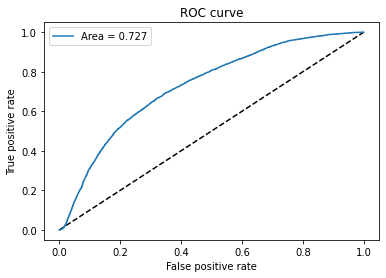

In [165]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [166]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','DNN (2 layer dropout)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
19,DNN (2 layer dropout),0.638596,0.636733,0.626222,0.638677,0.637305,0.641473,0.727494,47.754371,1.857913


In [167]:
results_df=results_df.append(df,ignore_index=True)
results_df


,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (2 layer),0.576283,0.711237,0.583605,0.703883,0.577837,0.713031,0.771145,85.106282,1.986335
1,DNN (2 layer dropout),0.638596,0.636733,0.626222,0.638677,0.637305,0.641473,0.727494,47.754371,1.857913


### Plotting the performance 


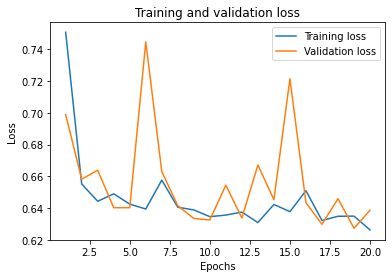

In [168]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

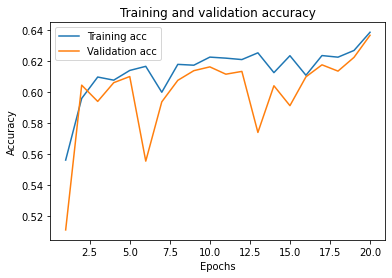

In [169]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 3: CNN with 2 convolutional layers, batchsize 100

In [170]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 4096)            

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [172]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 60010 samples, validate on 10590 samples
Epoch 1/15
60010/60010 [==============================] - 12s 200us/step - loss: 0.5267 - accuracy: 0.7438 - val_loss: 0.5116 - val_accuracy: 0.7588
Epoch 2/15
60010/60010 [==============================] - 11s 189us/step - loss: 0.4881 - accuracy: 0.7726 - val_loss: 0.4652 - val_accuracy: 0.7862
Epoch 3/15
60010/60010 [==============================] - 11s 189us/step - loss: 0.4714 - accuracy: 0.7830 - val_loss: 0.4939 - val_accuracy: 0.7671
Epoch 4/15
60010/60010 [==============================] - 11s 189us/step - loss: 0.4623 - accuracy: 0.7868 - val_loss: 0.4713 - val_accuracy: 0.7781
Epoch 5/15
60010/60010 [==============================] - 11s 188us/step - loss: 0.4513 - accuracy: 0.7958 - val_loss: 0.4659 - val_accuracy: 0.7849
Epoch 6/15
60010/60010 [==============================] - 11s 189us/step - loss: 0.4445 - accuracy: 0.7993 - val_loss: 0.4446 - val_accuracy: 0.7941
Epoch 7/15
60010/60010 [==============================] 

In [173]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

170.537865

##Test the model

In [174]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

17650/17650 [==============================] - 2s 139us/step


(0.42453519571266496, 0.809348464012146)

In [175]:
test_time = test_rt.process_time
test_time # in seconds

2.452826

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

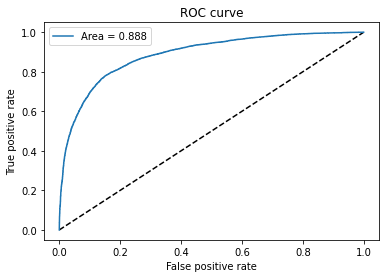

In [178]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [179]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers, batch100)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"CNN (2 layers, batch100)",0.421787,0.81152,0.384132,0.832495,0.424535,0.809348,0.887648,170.537865,2.452826


In [180]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (2 layer),0.576283,0.711237,0.583605,0.703883,0.577837,0.713031,0.771145,85.106282,1.986335
1,DNN (2 layer dropout),0.638596,0.636733,0.626222,0.638677,0.637305,0.641473,0.727494,47.754371,1.857913
2,"CNN (2 layers, batch100)",0.421787,0.811520,0.384132,0.832495,0.424535,0.809348,0.887648,170.537865,2.452826


### Plotting the performance 


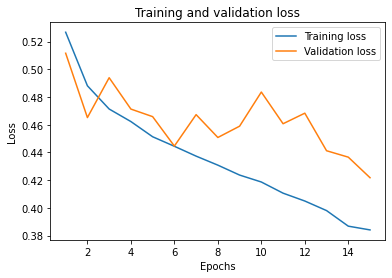

In [181]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

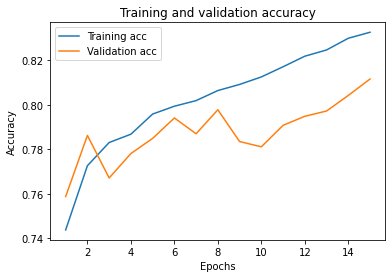

In [182]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Experiment 4: CNN with 2 convolutional layers, dropout

In [183]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(40, 40, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.3))

model.add(layers.Flatten())
model.add(layers.Dense(100, activation='relu'))
model.add(layers.Dropout(0.3))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 38, 38, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 19, 19, 32)        0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 19, 19, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 17, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_23 (Dropout)         (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 4096)            

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

##Train the model

In [185]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 60010 samples, validate on 10590 samples
Epoch 1/15
60010/60010 [==============================] - 7s 123us/step - loss: 0.6872 - accuracy: 0.5407 - val_loss: 0.6789 - val_accuracy: 0.6242
Epoch 2/15
60010/60010 [==============================] - 7s 116us/step - loss: 0.5863 - accuracy: 0.7375 - val_loss: 0.5627 - val_accuracy: 0.7391
Epoch 3/15
60010/60010 [==============================] - 7s 115us/step - loss: 0.5607 - accuracy: 0.7404 - val_loss: 0.5733 - val_accuracy: 0.7160
Epoch 4/15
60010/60010 [==============================] - 7s 115us/step - loss: 0.5416 - accuracy: 0.7510 - val_loss: 0.5702 - val_accuracy: 0.7042
Epoch 5/15
60010/60010 [==============================] - 7s 115us/step - loss: 0.5271 - accuracy: 0.7567 - val_loss: 0.5116 - val_accuracy: 0.7621
Epoch 6/15
60010/60010 [==============================] - 7s 116us/step - loss: 0.5184 - accuracy: 0.7607 - val_loss: 0.5013 - val_accuracy: 0.7717
Epoch 7/15
60010/60010 [==============================] - 7s 1

In [186]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

104.448857

##Test the model

In [187]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

17650/17650 [==============================] - 2s 136us/step


(0.48010401065221253, 0.7819263339042664)

In [188]:
test_time = test_rt.process_time
test_time # in seconds

2.409551

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

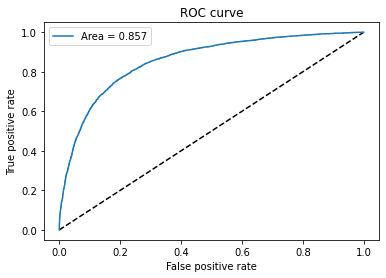

In [191]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
# results_df = history_df.iloc[-1:].copy()
# results_df.insert(0,'model','VGG16, 6 thawed batch100') 
# results_df['test_loss'] = test_loss #incorporate test results
# results_df['test_accuracy'] = test_acc
# results_df['auroc'] = auc_keras
# results_df['train time'] = train_time    
# results_df['test time'] = test_time    
# results_df

In [193]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','CNN (2 layers, batch1000)') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"CNN (2 layers, batch1000)",0.475503,0.781209,0.487969,0.776554,0.480104,0.781926,0.857317,104.448857,2.409551


In [194]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (2 layer),0.576283,0.711237,0.583605,0.703883,0.577837,0.713031,0.771145,85.106282,1.986335
1,DNN (2 layer dropout),0.638596,0.636733,0.626222,0.638677,0.637305,0.641473,0.727494,47.754371,1.857913
2,"CNN (2 layers, batch100)",0.421787,0.811520,0.384132,0.832495,0.424535,0.809348,0.887648,170.537865,2.452826
3,"CNN (2 layers, batch1000)",0.475503,0.781209,0.487969,0.776554,0.480104,0.781926,0.857317,104.448857,2.409551


### Plotting the performance 


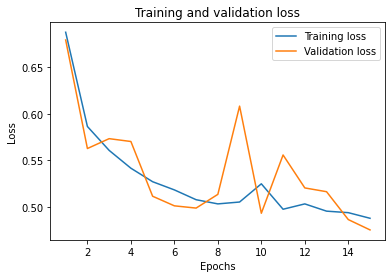

In [195]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

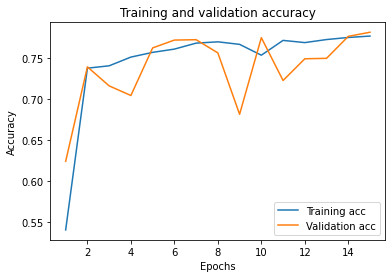

In [196]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

###Confusion matrix
True (row) and predicted (column) values

In [0]:
# Get the predicted classes:
pred_classes = model.predict_classes(X_train)

In [198]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, pred_classes)
conf_mx

array([[29108,  6160],
       [ 9157, 26175]])

#Feature Extraction

In [0]:
train_names[3]

'37f0d8cc90045cfe381b8000b8fbc5637c564778.tif'

In [0]:
# map sample image to array
img_path = train_path + '/' + train_names[3]

from keras.preprocessing import image                             

img = image.load_img(img_path, target_size=(40, 40))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.                                                
print(img_tensor.shape)  

(1, 40, 40, 3)


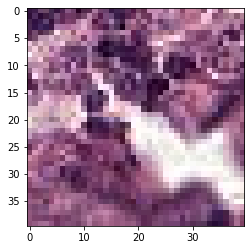

In [0]:
# display sample image
plt.imshow(img_tensor[0])
plt.show()

In [0]:
# instantiate a model from an input tensor and list of output tensors
layer_outputs = [layer.output for layer in model.layers[:8]]               
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [0]:
activations = activation_model.predict(img_tensor)

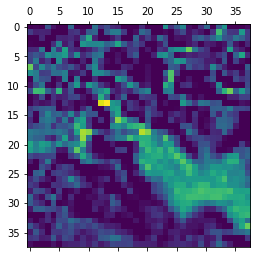

In [0]:
# activation of the first convolution layer for the sample image input
first_layer_activation = activations[0]
plt.matshow(first_layer_activation[0, :, :, 7], cmap='viridis')

In [0]:
# every channel in every intermediate activation
layer_names = []                                                          
for layer in model.layers[:8]:                                            
    layer_names.append(layer.name)                                        

images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):        
    n_features = layer_activation.shape[-1]                               

    size = layer_activation.shape[1]                                      

    n_cols = n_features // images_per_row                                 
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):                                             
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean()                         
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,                   
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


#Export Results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam110k_cnnEqual.csv')
files.download('PCam110k_cnnEqual.csv')

#Pre-trained Network: VGG16

In [0]:
from keras.applications import VGG16

## VGG16 3 layers thawed

###Instantiate the model

Do not use dropout initially

In [0]:
from keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))

model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 17s 310us/step - loss: 0.4729 - accuracy: 0.7848 - val_loss: 0.4289 - val_accuracy: 0.8045
Epoch 2/15
54400/54400 [==============================] - 16s 298us/step - loss: 0.4146 - accuracy: 0.8130 - val_loss: 0.4086 - val_accuracy: 0.8130
Epoch 3/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3969 - accuracy: 0.8210 - val_loss: 0.3999 - val_accuracy: 0.8195
Epoch 4/15
54400/54400 [==============================] - 16s 298us/step - loss: 0.3754 - accuracy: 0.8327 - val_loss: 0.4004 - val_accuracy: 0.8201
Epoch 5/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3617 - accuracy: 0.8416 - val_loss: 0.4019 - val_accuracy: 0.8241
Epoch 6/15
54400/54400 [==============================] - 16s 299us/step - loss: 0.3448 - accuracy: 0.8483 - val_loss: 0.4156 - val_accuracy: 0.8181
Epoch 7/15
54400/54400 [==============================] -

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

244.583603

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 5s 308us/step


(0.654116459608078, 0.8091874718666077)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

4.925948

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

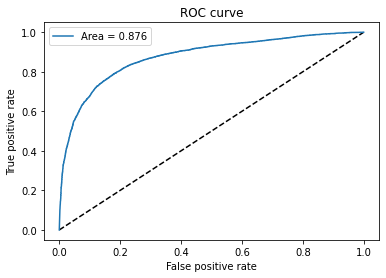

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
14,"VGG16, 3 thawed",0.651987,0.806562,0.196915,0.917794,0.654116,0.809187,244.583603,4.925948


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,train time,test time
0,DNN (1 layer),0.588970,0.679271,0.586518,0.689687,0.594717,0.670125,61.349588,1.563415
1,DNN (2 layer dropout),0.567190,0.709271,0.560058,0.709743,0.571902,0.712375,85.752367,1.706699
2,CNN (2 layers),0.523904,0.797708,0.234002,0.907776,0.535761,0.792063,87.033493,1.846106
3,"CNN (2 layers, D)",0.406787,0.817083,0.355217,0.846379,0.404930,0.821875,89.789792,1.926839
4,"VGG16, 3 thawed",0.651987,0.806562,0.196915,0.917794,0.654116,0.809187,244.583603,4.925948


### Plotting the performance 


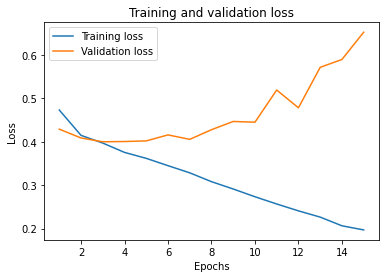

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

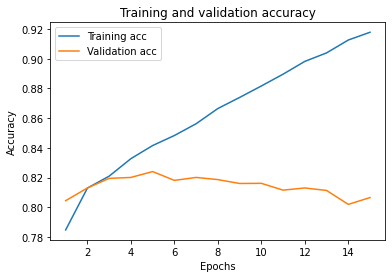

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 3 layers with Dropout

In [0]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

58892288/58889256 [==============================] - 3s 0us/step
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_6 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 52s 950us/step - loss: 0.4571 - accuracy: 0.7900 - val_loss: 0.4183 - val_accuracy: 0.8080
Epoch 2/15
54400/54400 [==============================] - 50s 927us/step - loss: 0.4112 - accuracy: 0.8165 - val_loss: 0.4132 - val_accuracy: 0.8130
Epoch 3/15
54400/54400 [==============================] - 51s 928us/step - loss: 0.3895 - accuracy: 0.8270 - val_loss: 0.4137 - val_accuracy: 0.8117
Epoch 4/15
54400/54400 [==============================] - 50s 926us/step - loss: 0.3758 - accuracy: 0.8355 - val_loss: 0.4086 - val_accuracy: 0.8159
Epoch 5/15
54400/54400 [==============================] - 51s 929us/step - loss: 0.3603 - accuracy: 0.8444 - val_loss: 0.4146 - val_accuracy: 0.8173
Epoch 6/15
54400/54400 [==============================] - 50s 927us/step - loss: 0.3472 - accuracy: 0.8497 - val_loss: 0.4234 - val_accuracy: 0.8129
Epoch 7/15
54400/54400 [==============================] -

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

757.410375

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 771us/step


(0.6457765243202448, 0.8058750033378601)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

12.342323

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

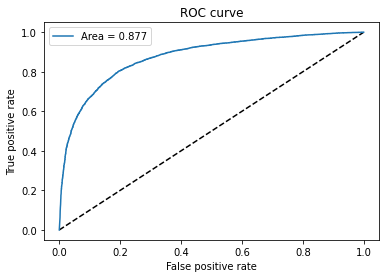

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 3 thawed, D') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 3 thawed, D",0.644842,0.813854,0.21415,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323


### Plotting the performance 


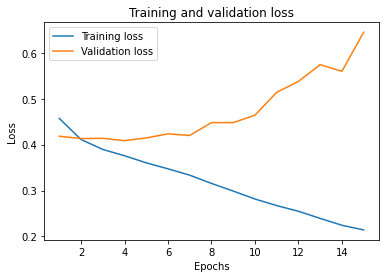

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

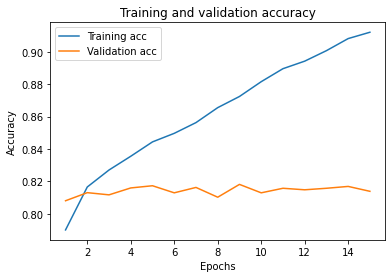

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5) with Dropout batch size 100

In [199]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_15 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [202]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 60010 samples, validate on 10590 samples
Epoch 1/15
60010/60010 [==============================] - 79s 1ms/step - loss: 0.4868 - accuracy: 0.7681 - val_loss: 0.4742 - val_accuracy: 0.7849
Epoch 2/15
60010/60010 [==============================] - 78s 1ms/step - loss: 0.4292 - accuracy: 0.8041 - val_loss: 0.5220 - val_accuracy: 0.7694
Epoch 3/15
60010/60010 [==============================] - 78s 1ms/step - loss: 0.4120 - accuracy: 0.8130 - val_loss: 0.4061 - val_accuracy: 0.8128
Epoch 4/15
60010/60010 [==============================] - 78s 1ms/step - loss: 0.3957 - accuracy: 0.8228 - val_loss: 0.4171 - val_accuracy: 0.8017
Epoch 5/15
60010/60010 [==============================] - 78s 1ms/step - loss: 0.3838 - accuracy: 0.8290 - val_loss: 0.3836 - val_accuracy: 0.8278
Epoch 6/15
60010/60010 [==============================] - 78s 1ms/step - loss: 0.3760 - accuracy: 0.8334 - val_loss: 0.4182 - val_accuracy: 0.8071
Epoch 7/15
60010/60010 [==============================] - 78s 1ms/st

In [203]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1167.901977

###Test the model

In [204]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

17650/17650 [==============================] - 13s 752us/step


(0.39451818885107554, 0.8299149870872498)

In [205]:
test_time = test_rt.process_time
test_time # in seconds

13.284263

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

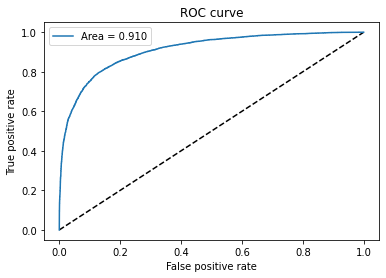

In [208]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [209]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 6 thawed batch100') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 6 thawed batch100",0.393021,0.832483,0.323083,0.861323,0.394518,0.829915,0.910069,1167.901977,13.284263


In [210]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (2 layer),0.576283,0.711237,0.583605,0.703883,0.577837,0.713031,0.771145,85.106282,1.986335
1,DNN (2 layer dropout),0.638596,0.636733,0.626222,0.638677,0.637305,0.641473,0.727494,47.754371,1.857913
2,"CNN (2 layers, batch100)",0.421787,0.811520,0.384132,0.832495,0.424535,0.809348,0.887648,170.537865,2.452826
3,"CNN (2 layers, batch1000)",0.475503,0.781209,0.487969,0.776554,0.480104,0.781926,0.857317,104.448857,2.409551
4,"VGG16, 6 thawed batch100",0.393021,0.832483,0.323083,0.861323,0.394518,0.829915,0.910069,1167.901977,13.284263


### Plotting the performance 


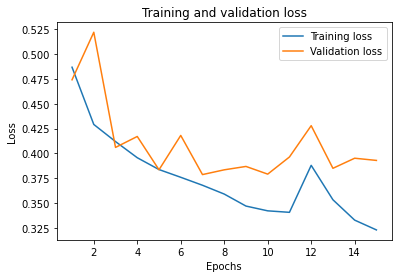

In [211]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

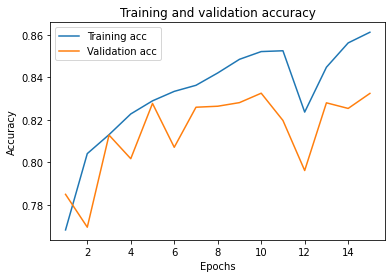

In [212]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 6 convolutional layers (block 4 and block 5) with Dropout

In [213]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_16 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block4_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [216]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 60010 samples, validate on 10590 samples
Epoch 1/15
60010/60010 [==============================] - 51s 849us/step - loss: 0.7589 - accuracy: 0.5044 - val_loss: 0.6929 - val_accuracy: 0.4938
Epoch 2/15
60010/60010 [==============================] - 47s 786us/step - loss: 0.6924 - accuracy: 0.5113 - val_loss: 0.6932 - val_accuracy: 0.4930
Epoch 3/15
60010/60010 [==============================] - 47s 786us/step - loss: 0.6931 - accuracy: 0.5025 - val_loss: 0.6932 - val_accuracy: 0.4930
Epoch 4/15
60010/60010 [==============================] - 47s 785us/step - loss: 0.6932 - accuracy: 0.5007 - val_loss: 0.6932 - val_accuracy: 0.4930
Epoch 5/15
60010/60010 [==============================] - 47s 785us/step - loss: 0.6932 - accuracy: 0.4990 - val_loss: 0.6932 - val_accuracy: 0.4930
Epoch 6/15
60010/60010 [==============================] - 47s 785us/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6933 - val_accuracy: 0.4930
Epoch 7/15
60010/60010 [==============================] 

In [217]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

710.31764

###Test the model

In [218]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

17650/17650 [==============================] - 13s 739us/step


(0.6931867810079126, 0.49818697571754456)

In [219]:
test_time = test_rt.process_time
test_time # in seconds

13.052063

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

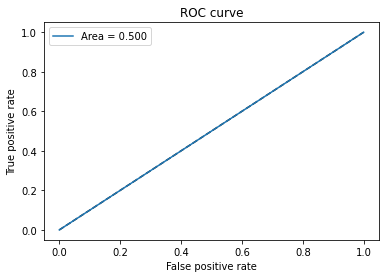

In [222]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [223]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 6 thawed batch1000') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 6 thawed batch1000",0.693249,0.493012,0.69317,0.5005,0.693187,0.498187,0.5,710.31764,13.052063


In [224]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (2 layer),0.576283,0.711237,0.583605,0.703883,0.577837,0.713031,0.771145,85.106282,1.986335
1,DNN (2 layer dropout),0.638596,0.636733,0.626222,0.638677,0.637305,0.641473,0.727494,47.754371,1.857913
2,"CNN (2 layers, batch100)",0.421787,0.811520,0.384132,0.832495,0.424535,0.809348,0.887648,170.537865,2.452826
3,"CNN (2 layers, batch1000)",0.475503,0.781209,0.487969,0.776554,0.480104,0.781926,0.857317,104.448857,2.409551
4,"VGG16, 6 thawed batch100",0.393021,0.832483,0.323083,0.861323,0.394518,0.829915,0.910069,1167.901977,13.284263
5,"VGG16, 6 thawed batch1000",0.693249,0.493012,0.693170,0.500500,0.693187,0.498187,0.500000,710.317640,13.052063


### Plotting the performance 


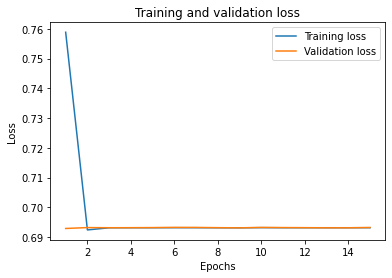

In [225]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

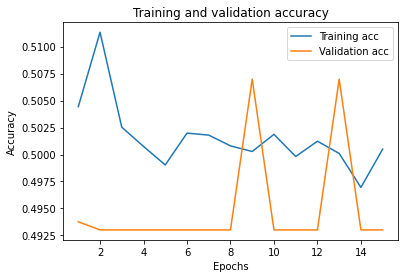

In [226]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 9 convolutional layers (blocks 3, 4, 5)

In [0]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
#model.add(layers.Dropout(0.25))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_8 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [0]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 100,
                    validation_split = 0.15)

Train on 54400 samples, validate on 9600 samples
Epoch 1/15
54400/54400 [==============================] - 85s 2ms/step - loss: 0.5721 - accuracy: 0.7096 - val_loss: 0.5046 - val_accuracy: 0.7682
Epoch 2/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4898 - accuracy: 0.7746 - val_loss: 0.4724 - val_accuracy: 0.7811
Epoch 3/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4592 - accuracy: 0.7919 - val_loss: 0.4359 - val_accuracy: 0.8048
Epoch 4/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4421 - accuracy: 0.8017 - val_loss: 0.4249 - val_accuracy: 0.8087
Epoch 5/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4196 - accuracy: 0.8138 - val_loss: 0.4495 - val_accuracy: 0.8014
Epoch 6/15
54400/54400 [==============================] - 84s 2ms/step - loss: 0.4058 - accuracy: 0.8200 - val_loss: 0.4136 - val_accuracy: 0.8213
Epoch 7/15
54400/54400 [==============================] - 84s 2ms/ste

In [0]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

1260.76891

###Test the model

In [0]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

16000/16000 [==============================] - 12s 727us/step


(0.3753491099178791, 0.8343124985694885)

In [0]:
test_time = test_rt.process_time
test_time # in seconds

11.634572

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

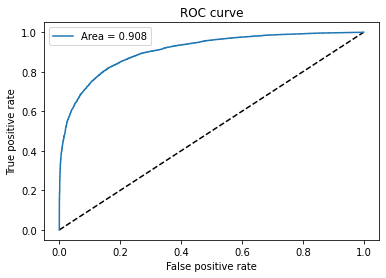

In [0]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [0]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 9 thawed') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.76891,11.634572


In [0]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,"CNN (2 layer, D)",0.414932,0.813125,0.368496,0.840717,0.416671,0.810812,0.889183,153.721501,2.190826
1,"DNN (1 layer, D)",0.625480,0.589167,0.632362,0.594596,0.623342,0.595563,0.649822,69.349039,1.669976
2,"VGG16, 3 thawed, D",0.644842,0.813854,0.214150,0.912132,0.645777,0.805875,0.877119,757.410375,12.342323
3,"VGG16, 6 thawed D",0.396917,0.833854,0.310740,0.868713,0.397511,0.831125,0.905549,1062.310632,11.847392
4,"VGG16, 9 thawed",0.384486,0.836667,0.346331,0.849853,0.375349,0.834312,0.908232,1260.768910,11.634572


### Plotting the performance 


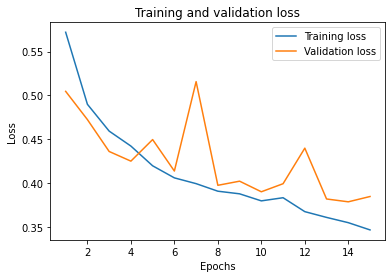

In [0]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

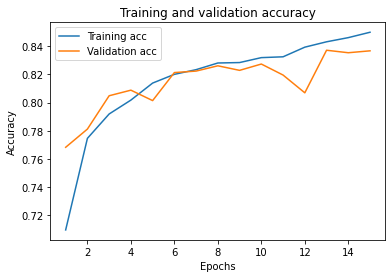

In [0]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

##VGG16 unfreeze 9 convolutional layers (blocks 3, 4, 5) with Dropout

In [227]:
conv_base = VGG16(weights = 'imagenet',
                     include_top = False,
                     input_shape = (40, 40, 3))

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_17 (Flatten)         (None, 512)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 256)               131328    
_________________________________________________________________
dropout_27 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 257       
Total params: 14,846,273
Trainable params: 14,846,273
Non-trainable params: 0
_________________________________________________________________


Select which layers to freeze during training

In [0]:
# Freeze all but the last three convolutional layers
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block3_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [0]:
model.compile(loss='binary_crossentropy', 
                   optimizer='adam',  
                   metrics=['accuracy'])

###Train the model

In [230]:
train_rt = TrainRuntimeCallback()
history = model.fit(X_train, 
                    y_train,
                    callbacks=[train_rt],
                    epochs=15,
                    batch_size = 1000,
                    validation_split = 0.15)

Train on 60010 samples, validate on 10590 samples
Epoch 1/15
60010/60010 [==============================] - 58s 970us/step - loss: 0.6533 - accuracy: 0.6075 - val_loss: 1.0223 - val_accuracy: 0.5264
Epoch 2/15
60010/60010 [==============================] - 58s 959us/step - loss: 0.5822 - accuracy: 0.7165 - val_loss: 0.5693 - val_accuracy: 0.7169
Epoch 3/15
60010/60010 [==============================] - 58s 960us/step - loss: 0.5244 - accuracy: 0.7551 - val_loss: 0.5622 - val_accuracy: 0.7469
Epoch 4/15
60010/60010 [==============================] - 58s 959us/step - loss: 0.5077 - accuracy: 0.7652 - val_loss: 0.5463 - val_accuracy: 0.7555
Epoch 5/15
60010/60010 [==============================] - 58s 958us/step - loss: 0.4889 - accuracy: 0.7763 - val_loss: 0.6057 - val_accuracy: 0.7207
Epoch 6/15
60010/60010 [==============================] - 58s 959us/step - loss: 0.4738 - accuracy: 0.7835 - val_loss: 0.5609 - val_accuracy: 0.7131
Epoch 7/15
60010/60010 [==============================] 

In [231]:
# Get the training time
train_time = train_rt.process_time
train_time # in seconds

864.322858

###Test the model

In [232]:
test_rt = TestRuntimeCallback()
test_loss, test_acc = model.evaluate(X_test, y_test, callbacks=[test_rt])
test_loss, test_acc

17650/17650 [==============================] - 13s 738us/step


(0.4011325173016648, 0.8232861161231995)

In [233]:
test_time = test_rt.process_time
test_time # in seconds

13.018625

###ROC and AUROC

In [0]:
#Generate predicted probabilities for X_test, and calculate FPR and TPR 
y_pred = model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [0]:
auc_keras = auc(fpr, tpr)

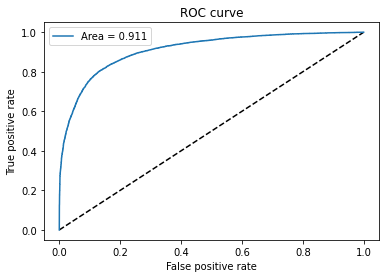

In [236]:
#Plot ROC
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Area = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

###Add training and test statistics to results dataframe

In [237]:
history_dict = history.history
history_df=pd.DataFrame(history_dict)
df = history_df.iloc[-1:].copy()
df.insert(0,'model','VGG16, 9 thawed Dropout batch1000') 
df['test_loss'] = test_loss 
df['test_accuracy'] = test_acc
df['auroc'] = auc_keras
df['train time'] = train_time     
df['test time'] = test_time   
df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
14,"VGG16, 9 thawed Dropout batch1000",0.399068,0.820019,0.392046,0.823779,0.401133,0.823286,0.910977,864.322858,13.018625


In [238]:
results_df=results_df.append(df,ignore_index=True)
results_df

,model,val_loss,val_accuracy,loss,accuracy,test_loss,test_accuracy,auroc,train time,test time
0,DNN (2 layer),0.576283,0.711237,0.583605,0.703883,0.577837,0.713031,0.771145,85.106282,1.986335
1,DNN (2 layer dropout),0.638596,0.636733,0.626222,0.638677,0.637305,0.641473,0.727494,47.754371,1.857913
2,"CNN (2 layers, batch100)",0.421787,0.811520,0.384132,0.832495,0.424535,0.809348,0.887648,170.537865,2.452826
3,"CNN (2 layers, batch1000)",0.475503,0.781209,0.487969,0.776554,0.480104,0.781926,0.857317,104.448857,2.409551
4,"VGG16, 6 thawed batch100",0.393021,0.832483,0.323083,0.861323,0.394518,0.829915,0.910069,1167.901977,13.284263
5,"VGG16, 6 thawed batch1000",0.693249,0.493012,0.693170,0.500500,0.693187,0.498187,0.500000,710.317640,13.052063
6,"VGG16, 9 thawed Dropout batch1000",0.399068,0.820019,0.392046,0.823779,0.401133,0.823286,0.910977,864.322858,13.018625


### Plotting the performance 


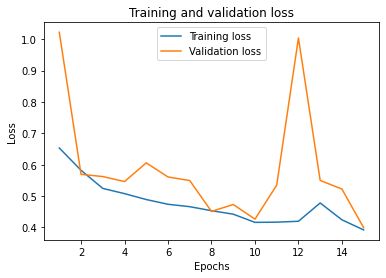

In [239]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

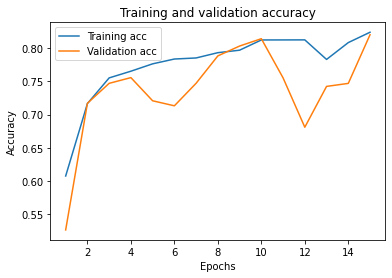

In [240]:
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
# val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

#Export results

In [241]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam110k_cnnEvenDistrib.csv')
files.download('PCam110k_cnnEvenDistrib.csv')

MessageError: ignored

#Visualizing findings

###Confusion matrix
True (row) and predicted (column) values

In [0]:
# Get the predicted classes:
pred_classes = model.predict_classes(X_train)

In [0]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_train, pred_classes)
conf_mx

array([[37130,   872],
       [ 1092, 24906]])

#Export results

In [0]:
#Export results dataframe

from google.colab import files

results_df.to_csv('PCam80k_resnet3_6.csv')
files.download('PCam80k_resnet3_6.csv')